# Benchmarking overview

This notebook contains the benchmark experiments for the paper using the LFR and CiGRAM generators as models.

In [1]:
%matplotlib inline
import networkx as nx
import cluster_query_tool
from subprocess import check_output
import networkx as nx
from collections import defaultdict
import numpy as np
from collections import defaultdict
from cluster_query_tool.louvain_consensus import mu_ivector
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score
import os
import seaborn as sns
from scipy import interp
import json

In [4]:
from cigram import lfr_benchmark_graph
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import random
import numpy as np
from cluster_query_tool.indexer import get_index
import logging

from scipy.special import binom
import itertools

logger = logging.getLogger("cigram.generators")
logger.setLevel(logging.ERROR)

def param_modifier(params, param, values):
    for val in values:
        nparams = params.copy()
        nparams[param] = val
        yield nparams


def _set_seed(params):
    params["seed"] = random.randint(1, 10000000)
    return params

    
def gen_benchmark(params, seed, samples, n_jobs=cpu_count()):
    random.seed(seed)
    res = Parallel(n_jobs=n_jobs)(delayed(lfr_benchmark_graph)(**_set_seed(params)) for _ in range(samples))
    return res


def get_benchmarks(base_params, modified_params, param_vals, seed, samples):
    for pset in param_modifier(base_params, modified_params, param_vals):
        benchmarks = gen_benchmark(pset, seed, samples)
        for graph, communities in benchmarks:
            yield graph, communities, get_index(graph, space_sample_size=1)

            
def roc_score_node(n, graph, index, node_comms):
    vec, key = mu_ivector(graph, index, [n])
    inc = lambda x: 1 if x in node_comms[n] else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]

    return roc_auc_score(y_true, y_score)


def roc_score_seed(seed_set, graph, index, comm):
    vec, key = mu_ivector(graph, index, seed_set)
    inc = lambda x: 1 if x in comm else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]
    return roc_auc_score(y_true, y_score)


def unique_sampler(node_set, sample_size, max_samples=24):
    sample_sets = set()
    
    # maximum number of samples
    sspace = binom(len(node_set), sample_size)
    if sspace > max_samples:
        
        if sspace > max_samples * 2:
            # problem with this loop is when max_samples is close to n choose k
            while len(sample_sets) < max_samples:
                samp = tuple(sorted(np.random.choice(node_set, sample_size, replace=False)))
                sample_sets.add(samp)
        else:
            # Generate max_samples, unique random numbers sampling without replacement from possible combinations
            # Faster than above loop in case where n choose k is close to max_samples
            sp = np.random.choice(range(int(binom(len(node_set), sample_size))), max_samples, replace=False)
            poss = list(itertools.combinations(node_set, sample_size))
            for s in  sp:
                sample_sets.add(poss[s])
            
    else:
        sample_sets = set(itertools.combinations(node_set, sample_size))
    
    return sample_sets


def get_auc_scores_community(seed_size, community, graph, index):
    samples = unique_sampler(community, seed_size)
    np.random.seed(1337)
    auc_scores = Parallel(n_jobs=24) ( delayed(roc_score_seed)(sample, graph, index, comm) for sample in samples )
    
    return auc_scores

In [30]:
results = {}
stdev_res = {}

resfile = "lfr_mu_class_resfile.json"
if os.path.exists(resfile):
    with open(resfile) as res:
        rf = json.load(res)
        results = rf["results"]
        stdev_res = rf["std"]

In [59]:
from collections import defaultdict
import json
params = dict(
    n=1000,
    average_degree=20,
    max_degree=50,
    minc_size=10,
    maxc_size=50,
)
network_samples = 2
seed = 1339

seed_sizes = [1, 3, 7, 15]

mu_vals = np.linspace(0.01, 1, 10)


test = params.copy()
test["mu"] = 0.7
test["seed"] = seed
%time graph, communities = lfr_benchmark_graph(**test)
%time index = get_index(graph, use_cache=True)

CPU times: user 524 ms, sys: 4 ms, total: 528 ms
Wall time: 524 ms
CPU times: user 584 ms, sys: 20 ms, total: 604 ms
Wall time: 600 ms


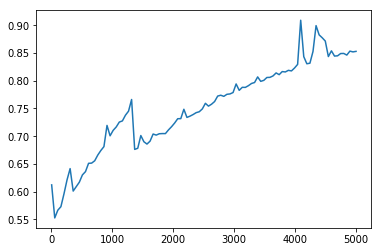

In [38]:
def _t():
    for community in communities.values():
        samples = unique_sampler(community, 30, max_samples=120)
        for sample in samples:
            mu_ivector(graph, index, sample)

# %time _t()

import time
total = []
nodes = list(graph.nodes())
for s in np.linspace(10, len(nodes), 100).astype(int):
    start = time.time()
    opt = mu_ivector(graph, index, nodes[:s])
    
    end = time.time()
    
    total.append(end - start)
    
plt.plot(np.linspace(10, len(nodes), 100), total)

In [65]:
ks = []
for graph, communities, index in get_benchmarks(params, "mu", mu_vals, seed, 1):
    print(graph.name)
    ks.append(len(communities))
    
np.mean(ks)

03/14/2018 11:35:53 AM Calling LFR Code
03/14/2018 11:35:53 AM Setting random seed
03/14/2018 11:35:53 AM Generating benchmark
03/14/2018 11:35:53 AM Benchmark starting 
03/14/2018 11:35:53 AM community size range automatically set
03/14/2018 11:35:53 AM Node degrees 
03/14/2018 11:35:53 AM Node degrees internal
03/14/2018 11:35:53 AM IDEG _MEMBERSHIP
03/14/2018 11:35:53 AM Calling powerlaw to generate community distribution
03/14/2018 11:35:53 AM Setting internal degree
03/14/2018 11:35:53 AM Setting Memberships
03/14/2018 11:35:53 AM it took too long to decide the memberships; I will try to change the community sizes
03/14/2018 11:35:53 AM IDEG _MEMBERSHIP
03/14/2018 11:35:53 AM Calling powerlaw to generate community distribution
03/14/2018 11:35:53 AM Setting internal degree
03/14/2018 11:35:53 AM Setting Memberships
03/14/2018 11:35:53 AM Memberships assigned
03/14/2018 11:35:53 AM Return internal degree
03/14/2018 11:35:53 AM building communities... 
03/14/2018 11:35:53 AM connect

lfr_binary_1000-20.0-2.0-1.0-0.01--214741.0-50-0-0-10-50-3463553-False-False-False


03/14/2018 11:35:54 AM Calling LFR Code
03/14/2018 11:35:54 AM Setting random seed
03/14/2018 11:35:54 AM Generating benchmark
03/14/2018 11:35:54 AM Benchmark starting 
03/14/2018 11:35:54 AM community size range automatically set
03/14/2018 11:35:54 AM Node degrees 
03/14/2018 11:35:54 AM Node degrees internal
03/14/2018 11:35:54 AM IDEG _MEMBERSHIP
03/14/2018 11:35:54 AM Calling powerlaw to generate community distribution
03/14/2018 11:35:54 AM Setting internal degree
03/14/2018 11:35:54 AM Setting Memberships
03/14/2018 11:35:54 AM Memberships assigned
03/14/2018 11:35:54 AM Return internal degree
03/14/2018 11:35:54 AM building communities... 
03/14/2018 11:35:55 AM connecting communities... 
03/14/2018 11:35:55 AM Benchmark complete
03/14/2018 11:35:55 AM Building network py objects
03/14/2018 11:35:55 AM Building return list 
03/14/2018 11:35:55 AM Exit LFR Code


lfr_binary_1000-20.0-2.0-1.0-0.12--214741.0-50-0-0-10-50-3463553-False-False-False


03/14/2018 11:35:56 AM Calling LFR Code
03/14/2018 11:35:56 AM Setting random seed
03/14/2018 11:35:56 AM Generating benchmark
03/14/2018 11:35:56 AM Benchmark starting 
03/14/2018 11:35:56 AM community size range automatically set
03/14/2018 11:35:56 AM Node degrees 
03/14/2018 11:35:56 AM Node degrees internal
03/14/2018 11:35:56 AM IDEG _MEMBERSHIP
03/14/2018 11:35:56 AM Calling powerlaw to generate community distribution
03/14/2018 11:35:56 AM Setting internal degree
03/14/2018 11:35:56 AM Setting Memberships
03/14/2018 11:35:56 AM Memberships assigned
03/14/2018 11:35:56 AM Return internal degree
03/14/2018 11:35:56 AM building communities... 
03/14/2018 11:35:56 AM connecting communities... 
03/14/2018 11:35:56 AM Benchmark complete
03/14/2018 11:35:56 AM Building network py objects
03/14/2018 11:35:56 AM Building return list 
03/14/2018 11:35:56 AM Exit LFR Code


lfr_binary_1000-20.0-2.0-1.0-0.23--214741.0-50-0-0-10-50-3463553-False-False-False


03/14/2018 11:35:57 AM Calling LFR Code
03/14/2018 11:35:57 AM Setting random seed
03/14/2018 11:35:57 AM Generating benchmark
03/14/2018 11:35:57 AM Benchmark starting 
03/14/2018 11:35:57 AM community size range automatically set
03/14/2018 11:35:57 AM Node degrees 
03/14/2018 11:35:57 AM Node degrees internal
03/14/2018 11:35:57 AM IDEG _MEMBERSHIP
03/14/2018 11:35:57 AM Calling powerlaw to generate community distribution
03/14/2018 11:35:57 AM Setting internal degree
03/14/2018 11:35:57 AM Setting Memberships
03/14/2018 11:35:57 AM Memberships assigned
03/14/2018 11:35:57 AM Return internal degree
03/14/2018 11:35:57 AM building communities... 
03/14/2018 11:35:57 AM connecting communities... 
03/14/2018 11:35:57 AM Benchmark complete
03/14/2018 11:35:57 AM Building network py objects
03/14/2018 11:35:57 AM Building return list 
03/14/2018 11:35:57 AM Exit LFR Code


lfr_binary_1000-20.0-2.0-1.0-0.34--214741.0-50-0-0-10-50-3463553-False-False-False


03/14/2018 11:35:58 AM Calling LFR Code
03/14/2018 11:35:58 AM Setting random seed
03/14/2018 11:35:58 AM Generating benchmark
03/14/2018 11:35:58 AM Benchmark starting 
03/14/2018 11:35:58 AM community size range automatically set
03/14/2018 11:35:58 AM Node degrees 
03/14/2018 11:35:58 AM Node degrees internal
03/14/2018 11:35:58 AM IDEG _MEMBERSHIP
03/14/2018 11:35:58 AM Calling powerlaw to generate community distribution
03/14/2018 11:35:58 AM Setting internal degree
03/14/2018 11:35:58 AM Setting Memberships
03/14/2018 11:35:58 AM Memberships assigned
03/14/2018 11:35:58 AM Return internal degree
03/14/2018 11:35:58 AM building communities... 
03/14/2018 11:35:58 AM connecting communities... 
03/14/2018 11:35:59 AM Benchmark complete
03/14/2018 11:35:59 AM Building network py objects
03/14/2018 11:35:59 AM Building return list 
03/14/2018 11:35:59 AM Exit LFR Code


lfr_binary_1000-20.0-2.0-1.0-0.45--214741.0-50-0-0-10-50-3463553-False-False-False


03/14/2018 11:36:41 AM Calling LFR Code
03/14/2018 11:36:41 AM Setting random seed
03/14/2018 11:36:41 AM Generating benchmark
03/14/2018 11:36:41 AM Benchmark starting 
03/14/2018 11:36:41 AM community size range automatically set
03/14/2018 11:36:41 AM Node degrees 
03/14/2018 11:36:41 AM Node degrees internal
03/14/2018 11:36:41 AM IDEG _MEMBERSHIP
03/14/2018 11:36:41 AM Calling powerlaw to generate community distribution
03/14/2018 11:36:41 AM Setting internal degree
03/14/2018 11:36:41 AM Setting Memberships
03/14/2018 11:36:41 AM Memberships assigned
03/14/2018 11:36:41 AM Return internal degree
03/14/2018 11:36:41 AM building communities... 
03/14/2018 11:36:41 AM connecting communities... 
03/14/2018 11:36:42 AM Benchmark complete
03/14/2018 11:36:42 AM Building network py objects
03/14/2018 11:36:42 AM Building return list 
03/14/2018 11:36:42 AM Exit LFR Code
Process ForkPoolWorker-942:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py",

KeyboardInterrupt: 

In [20]:
for seed_size in seed_sizes:
    print(seed_size)
    if str(seed_size) not in results:
        results[str(seed_size)] = []
        stdev_res[str(seed_size)] = []
        for graph, communities, index in get_benchmarks(params, "mu", mu_vals, seed, net_samples):
            tps = []
            for comm in communities.values():
                if len(comm) > seed_size:
                    auc_scores = get_auc_scores_community(seed_size, comm, graph, index)
                    tps.append(np.mean(auc_scores))

        results[str(seed_size)].append(np.mean(tps))
        stdev_res[str(seed_size)].append(np.std(tps))
    print(seed_size, results[str(seed_size)])

1


NameError: name 'results' is not defined

In [ ]:
import json
with open(resfile, "w+") as res:
    json.dump(dict(results=results, std=stdev_res), res)
    

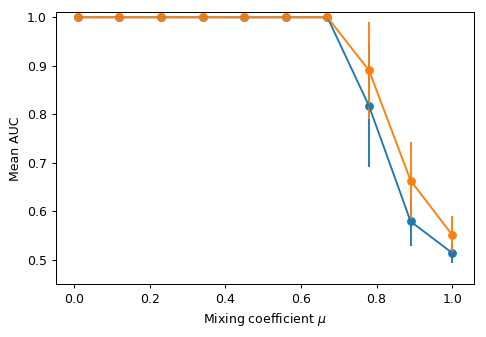

In [21]:
with open(resfile) as res:
    rf = json.load(res)
    results = rf["results"]
    stdev_res = rf["std"]

fig, ax = plt.subplots()
fig.set_dpi(90)
ax.set_ylabel("Mean AUC")
ax.set_xlabel("Mixing coefficient $\mu$")

ax.set_ylim(0.45, 1.01)
for seed_size in seed_sizes:
    if str(seed_size) in results:
        ax.scatter(mu_vals, results[str(seed_size)],)
        ax.errorbar(mu_vals, results[str(seed_size)], yerr=stdev_res[str(seed_size)])

fig.savefig("figs/nodewise_classification_lfr_mu.eps")
fig.savefig("figs/nodewise_classification_lfr_mu.svg")
fig.savefig("figs/nodewise_classification_lfr_mu.png")

In [7]:
seed = 1
params = dict(
    n=100,
    mu=0.1,
    average_degree=20,
    max_degree=50,
    minc_size=10,
    maxc_size=50,
    overlapping_memberships=20,
)

samples = 10
overlap_vals = np.linspace(0.0, 0.5, 10)
overlap_vals *= params["n"]


for graph, communities, index in get_benchmarks(params, "overlapping_nodes", overlap_vals.astype(int), seed, samples):
    print(graph.number_of_edges())

985
983
913
1013
916
987
1016
982
1017
998


03/28/2018 01:29:07 PM it seems that the overlapping nodes need more communities that those I provided. Please increase the number of communities or decrease the number of overlapping nodes
03/28/2018 01:29:07 PM it seems that the overlapping nodes need more communities that those I provided. Please increase the number of communities or decrease the number of overlapping nodes
03/28/2018 01:29:07 PM it seems that the overlapping nodes need more communities that those I provided. Please increase the number of communities or decrease the number of overlapping nodes
03/28/2018 01:29:07 PM it seems that the overlapping nodes need more communities that those I provided. Please increase the number of communities or decrease the number of overlapping nodes
03/28/2018 01:29:07 PM it seems that the overlapping nodes need more communities that those I provided. Please increase the number of communities or decrease the number of overlapping nodes
03/28/2018 01:29:07 PM it seems that the overlappi

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7ff920b1c930, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/mbzjpg/repos/cluster_query_tool/venv/lib/p...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/mbzjpg.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7ff920b1c930, file "/...3.5/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/mbzjpg/repos/cluster_query_tool/venv/lib/p...ges/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/mbzjpg.../python3.5/site-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except RuntimeError:
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/usr/lib/python3.5/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    340             raise RuntimeError('Event loop is running.')
    341         self._set_coroutine_wrapper(self._debug)
    342         self._thread_id = threading.get_ident()
    343         try:
    344             while True:
--> 345                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    346                 if self._stopping:
    347                     break
    348         finally:
    349             self._stopping = False

...........................................................................
/usr/lib/python3.5/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1307                         logger.warning('Executing %s took %.3f seconds',
   1308                                        _format_handle(handle), dt)
   1309                 finally:
   1310                     self._current_handle = None
   1311             else:
-> 1312                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(13, 1)>>
   1313         handle = None  # Needed to break cycles when an exception occurs.
   1314 
   1315     def _set_coroutine_wrapper(self, enabled):
   1316         try:

...........................................................................
/usr/lib/python3.5/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(13, 1)>)
    120             self._callback = None
    121             self._args = None
    122 
    123     def _run(self):
    124         try:
--> 125             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (13, 1)
    126         except Exception as exc:
    127             cb = _format_callback_source(self._callback, self._args)
    128             msg = 'Exception in callback {}'.format(cb)
    129             context = {

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=13, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 12, 29, 1, 298914, tzinfo=tzutc()), 'msg_id': '3a1a00a7e2c548d48d95531cd74641e6', 'msg_type': 'execute_request', 'session': '384c5bd1e98a44ad955f1616e4d85c08', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3a1a00a7e2c548d48d95531cd74641e6', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'384c5bd1e98a44ad955f1616e4d85c08']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 12, 29, 1, 298914, tzinfo=tzutc()), 'msg_id': '3a1a00a7e2c548d48d95531cd74641e6', 'msg_type': 'execute_request', 'session': '384c5bd1e98a44ad955f1616e4d85c08', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3a1a00a7e2c548d48d95531cd74641e6', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'384c5bd1e98a44ad955f1616e4d85c08'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 28, 12, 29, 1, 298914, tzinfo=tzutc()), 'msg_id': '3a1a00a7e2c548d48d95531cd74641e6', 'msg_type': 'execute_request', 'session': '384c5bd1e98a44ad955f1616e4d85c08', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '3a1a00a7e2c548d48d95531cd74641e6', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.AugAssign object>, <_ast.For object>], cell_name='<ipython-input-7-3884e0de9c48>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7ff8af5ab630, executi..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7ff91849b1e0, file "<ipython-input-7-3884e0de9c48>", line 17>
        result = <ExecutionResult object at 7ff8af5ab630, executi..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7ff91849b1e0, file "<ipython-input-7-3884e0de9c48>", line 17>, result=<ExecutionResult object at 7ff8af5ab630, executi..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7ff91849b1e0, file "<ipython-input-7-3884e0de9c48>", line 17>
        self.user_global_ns = {'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...aborn as sns\nfrom scipy import interp\nimport json", 'from cigram import lfr_benchmark_graph\nfrom jobl...or sample in samples )\n    \n    return auc_scores', "get_ipython().run_line_magic('pinfo2', 'get_index')", 'from cigram import lfr_benchmark_graph\nfrom jobl...or sample in samples )\n    \n    return auc_scores', 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())'], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__loader__': None, ...}
        self.user_ns = {'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...aborn as sns\nfrom scipy import interp\nimport json", 'from cigram import lfr_benchmark_graph\nfrom jobl...or sample in samples )\n    \n    return auc_scores', "get_ipython().run_line_magic('pinfo2', 'get_index')", 'from cigram import lfr_benchmark_graph\nfrom jobl...or sample in samples )\n    \n    return auc_scores', 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())', 'seed = 1\nparams = dict(\n    n=100,\n    mu=0.1,\n ...eed, samples):\n    print(graph.number_of_edges())'], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', '__loader__': None, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/notebooks/<ipython-input-7-3884e0de9c48> in <module>()
     12 samples = 10
     13 overlap_vals = np.linspace(0.0, 0.5, 10)
     14 overlap_vals *= params["n"]
     15 
     16 
---> 17 for graph, communities, index in get_benchmarks(params, "overlapping_nodes", overlap_vals.astype(int), seed, samples):
     18     print(graph.number_of_edges())

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/notebooks/<ipython-input-4-0ea5179ea27e> in get_benchmarks(base_params={'average_degree': 20, 'max_degree': 50, 'maxc_size': 50, 'minc_size': 10, 'mu': 0.1, 'n': 100, 'overlapping_memberships': 20}, modified_params='overlapping_nodes', param_vals=array([ 0,  5, 11, 16, 22, 27, 33, 38, 44, 50]), seed=1, samples=10)
     32 
     33 def get_benchmarks(base_params, modified_params, param_vals, seed, samples):
     34     for pset in param_modifier(base_params, modified_params, param_vals):
     35         benchmarks = gen_benchmark(pset, seed, samples)
     36         for graph, communities in benchmarks:
---> 37             yield graph, communities, get_index(graph, space_sample_size=1)
     38 
     39             
     40 def roc_score_node(n, graph, index, node_comms):
     41     vec, key = mu_ivector(graph, index, [n])

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/cqt-0.0.1-py3.5.egg/cluster_query_tool/indexer.py in get_index(graph=<networkx.classes.graph.Graph object>, space_sample_size=1, seed=1, num_procs=24, use_cache=True)
     72             result = load(cache_location)
     73             return result
     74         except json.JSONDecodeError:
     75             pass
     76 
---> 77     result = gen_sample_sets(graph, num_samples=space_sample_size, num_procs=num_procs, seed=seed)
        result = undefined
        graph = <networkx.classes.graph.Graph object>
        space_sample_size = 1
        num_procs = 24
        seed = 1
     78 
     79     if use_cache:
     80         dump(result, cache_location)
     81         

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/cqt-0.0.1-py3.5.egg/cluster_query_tool/indexer.py in gen_sample_sets(graph=<networkx.classes.graph.Graph object>, num_procs=24, num_samples=1, seed=1)
    113 def gen_sample_sets(graph, num_procs=cpu_count(), num_samples=2000, seed=1):
    114     """
    115     Compute louvain accross multiple cores
    116     """
    117     cut_sets = Parallel(n_jobs=num_procs)(delayed(_sample_local_optima)(graph, s)
--> 118                                             for s in range(seed, seed+num_samples))
        seed = 1
        num_samples = 1
    119 
    120     cut_sets = list(set(cut_sets))
    121     # Only partition unique cut sets
    122     partitions = Parallel(n_jobs=num_procs)(delayed(partition_from_cut)(graph, cs) for cs in cut_sets)

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=24), iterable=<generator object gen_sample_sets.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=24)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Mar 28 13:29:08 2018
PID: 2121Python 3.5.2: /home/mbzjpg/repos/cluster_query_tool/venv/bin/python3
...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample_local_optima>, (<networkx.classes.graph.Graph object>, 1), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample_local_optima>
        args = (<networkx.classes.graph.Graph object>, 1)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/cqt-0.0.1-py3.5.egg/cluster_query_tool/indexer.py in _sample_local_optima(graph=<networkx.classes.graph.Graph object>, seed=1)
    100     :param graph:
    101     :param seed:
    102     :return:
    103     """
    104     random.seed(seed)
--> 105     start_partition, local_optima = gen_local_optima_community(graph)
        start_partition = undefined
        local_optima = undefined
        graph = <networkx.classes.graph.Graph object>
    106     # Hashable type
    107     cut_set = partition_to_cut_set(graph, local_optima)
    108     # Sometimes we generate an initial cut set that reduces to empty set
    109 

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/cqt-0.0.1-py3.5.egg/cluster_query_tool/louvain_consensus.py in gen_local_optima_community(graph=<networkx.classes.graph.Graph object>)
     46     return tuple(sorted(set([edge for edge in graph.edges() if partition[edge[0]] != partition[edge[1]]])))
     47 
     48 
     49 def gen_local_optima_community(graph):
     50     # The possible space of communities is huge!
---> 51     sample = random.sample(graph.edges(), random.randint(1, graph.number_of_edges()))
        sample = undefined
        graph.edges = EdgeView([])
        graph.number_of_edges = <bound method Graph.number_of_edges of <networkx.classes.graph.Graph object>>
     52     # convert to partition
     53     start_partition = create_partition_from_edge_set(graph, sample)
     54     local_optima = louvain.best_partition(graph, partition=start_partition)
     55 

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/random.py in randint(self=<random.Random object>, a=1, b=0)
    213 
    214     def randint(self, a, b):
    215         """Return random integer in range [a, b], including both end points.
    216         """
    217 
--> 218         return self.randrange(a, b+1)
        self.randrange = <bound method Random.randrange of <random.Random object>>
        a = 1
        b = 0
    219 
    220     def _randbelow(self, n, int=int, maxsize=1<<BPF, type=type,
    221                    Method=_MethodType, BuiltinMethod=_BuiltinMethodType):
    222         "Return a random int in the range [0,n).  Raises ValueError if n==0."

...........................................................................
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/random.py in randrange(self=<random.Random object>, start=1, stop=1, step=1, _int=<class 'int'>)
    191             raise ValueError("non-integer stop for randrange()")
    192         width = istop - istart
    193         if step == 1 and width > 0:
    194             return istart + self._randbelow(width)
    195         if step == 1:
--> 196             raise ValueError("empty range for randrange() (%d,%d, %d)" % (istart, istop, width))
        istart = 1
        istop = 1
        width = 0
    197 
    198         # Non-unit step argument supplied.
    199         istep = _int(step)
    200         if istep != step:

ValueError: empty range for randrange() (1,1, 0)
___________________________________________________________________________

In [3]:
get_index??